In [165]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
import torch.utils.data as data
from torchvision.utils import make_grid
import torch.optim as optim

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [166]:
input_data="../input/gtsrb-german-traffic-sign"
c1=os.listdir(input_data)
print(c1)

['Meta', 'meta', 'Meta.csv', 'Train.csv', 'Test.csv', 'Test', 'test', 'Train', 'train']


In [167]:
train_data="../input/gtsrb-german-traffic-sign/train"
classes=os.listdir(train_data)
print(classes)

['7', '17', '19', '22', '2', '35', '23', '10', '5', '36', '20', '27', '41', '39', '32', '25', '42', '8', '38', '12', '0', '31', '34', '18', '28', '16', '13', '26', '15', '3', '1', '30', '14', '4', '9', '21', '40', '6', '11', '37', '33', '29', '24']


In [168]:
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         # tt.RandomRotate
                         # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                         tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])
#valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [169]:
train_data_path ="../input/gtsrb-german-traffic-sign/train"
#val_data_path="../input/gtsrb-german-traffic-sign/Test"
train_data = torchvision.datasets.ImageFolder(root = train_data_path, transform =train_tfms)
#val_data=torchvision.datasets.ImageFolder(root=val_data_path,transform=valid_tfms)

In [170]:
val_len=3000
train_len=len(train_data)-val_len
train_data,val_data=data.random_split(train_data,[train_len,val_len])


In [171]:
len(train_data)

36209

In [172]:

BATCH_SIZE = 256
numClasses = 43

In [173]:
train_dl = DataLoader(train_data, shuffle=True, batch_size = BATCH_SIZE,num_workers=3,pin_memory=True)
valid_dl = DataLoader(val_data,batch_size = BATCH_SIZE*2,num_workers=3,pin_memory=True)

In [174]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means


In [175]:


def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

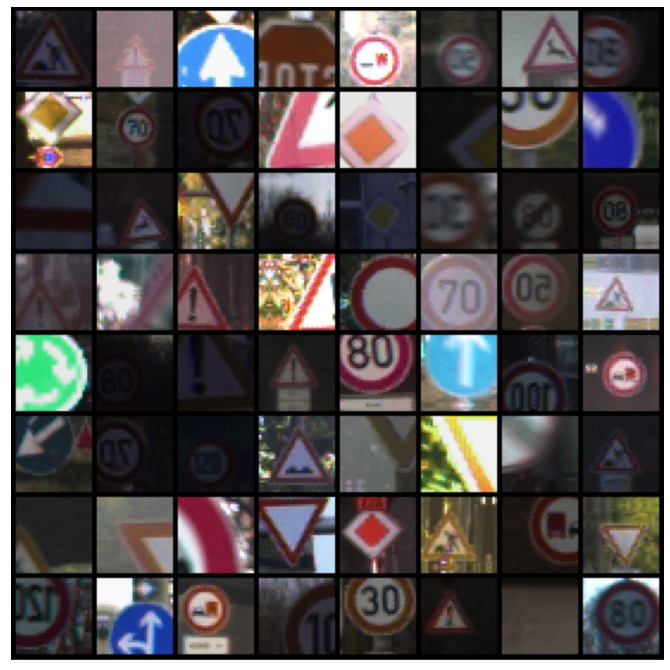

In [176]:
show_batch(train_dl)

In [177]:
!pip install jovian --upgrade -q

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [178]:
import jovian

In [179]:
project_name="01-German_traffic"
jovian.commit(project=project_name)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ai/pkjhamkt/01-German_traffic


<IPython.core.display.Javascript object>

In [180]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [181]:
device = get_default_device()
device

device(type='cuda')

In [182]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [183]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [184]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64,192, pool=True)
        self.res1 = nn.Sequential(conv_block(192,192), conv_block(192,192))
        
        self.conv3 = conv_block(192,384, pool=True)
        self.conv4 = conv_block(384,256, pool=True)
        self.res2 = nn.Sequential(conv_block(256, 256), conv_block(256,256))
        
        #self.conv5 = conv_block(256,512, pool=True)
        #self.conv6 = conv_block(256, 512, pool=True)
        #self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(256, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        #out = self.conv5(out)
        #out = self.conv6(out) 
        #out = self.res3(out) + out
        out = self.classifier(out)
        return out

In [185]:
model =to_device(ResNet9(3,43),device)
# Print model
print(model)


ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [186]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [187]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 3.7516028881073, 'val_acc': 0.021691525354981422}]

In [188]:
epochs = 15
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [189]:
%%time

history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00151, train_loss: 2.6843, val_loss: 1.9328, val_acc: 0.4452
Epoch [1], last_lr: 0.00435, train_loss: 1.2017, val_loss: 1.2470, val_acc: 0.6480
Epoch [2], last_lr: 0.00759, train_loss: 0.7717, val_loss: 1.7499, val_acc: 0.5387
Epoch [3], last_lr: 0.00971, train_loss: 0.5831, val_loss: 1.0831, val_acc: 0.7081
Epoch [4], last_lr: 0.00994, train_loss: 0.4904, val_loss: 0.7784, val_acc: 0.7646
Epoch [5], last_lr: 0.00950, train_loss: 0.4324, val_loss: 0.4867, val_acc: 0.8534
Epoch [6], last_lr: 0.00867, train_loss: 0.3969, val_loss: 0.4682, val_acc: 0.8581
Epoch [7], last_lr: 0.00750, train_loss: 0.3703, val_loss: 0.4164, val_acc: 0.8689
Epoch [8], last_lr: 0.00611, train_loss: 0.3454, val_loss: 0.3339, val_acc: 0.8923
Epoch [9], last_lr: 0.00463, train_loss: 0.3137, val_loss: 0.3747, val_acc: 0.8859
Epoch [10], last_lr: 0.00317, train_loss: 0.2712, val_loss: 0.2822, val_acc: 0.9101
Epoch [11], last_lr: 0.00188, train_loss: 0.2334, val_loss: 0.1956, val_acc: 0.9376
Ep

In [190]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

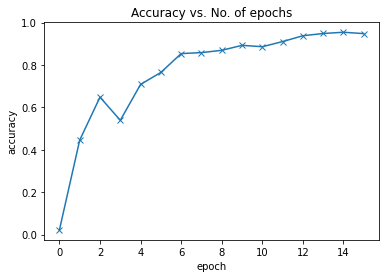

In [191]:
plot_accuracies(history)

In [192]:
jovian.commit(project=project_name)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ai/pkjhamkt/01-German_traffic


<IPython.core.display.Javascript object>

In [193]:
data_dir="../input/gtsrb-german-traffic-sign/Test"
test_class=os.listdir(data_dir)


In [194]:
from PIL import Image

In [217]:
import pandas as pd
df = pd.read_csv("../input/gtsrb-german-traffic-sign/Test.csv")
y_test=df['ClassId'].values
path_list =df['Path'].values

In [218]:
print(path_list)

['Test/00000.png' 'Test/00001.png' 'Test/00002.png' ... 'Test/12627.png'
 'Test/12628.png' 'Test/12629.png']


In [219]:
data=[]
for f in path_list:
    img = Image.open('../input/gtsrb-german-traffic-sign/Test/'+f.replace('Test/', ''))
    data_array=tt.ToTensor()
    img_PIL = tt.Resize([32,32])(img)
    img_ = tt.ToTensor()(img_PIL)
    data.append(img_)

In [220]:
test_loader =DataLoader(data, batch_size=BATCH_SIZE, shuffle=False)

In [221]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return preds.item()

Label: 16 , Predicted: 8


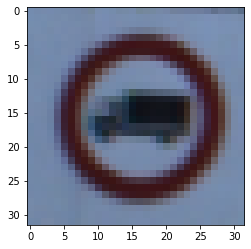

In [222]:
img= data[0]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:',y_test[0], ', Predicted:', predict_image(img, model))

Label: 38 , Predicted: 32


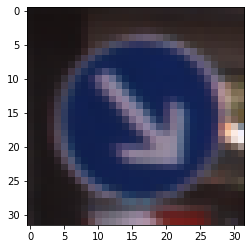

In [223]:
img= data[5]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:',y_test[5], ', Predicted:', predict_image(img, model))

Label: 12 , Predicted: 10


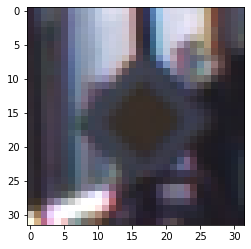

In [224]:
img= data[10]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:',y_test[10], ', Predicted:', predict_image(img, model))

Label: 1 , Predicted: 1


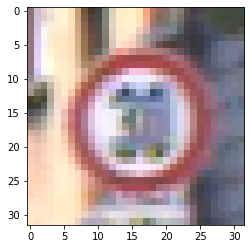

In [225]:
img= data[100]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:',y_test[100], ', Predicted:', predict_image(img, model))

In [229]:
def Test_accuracy(data):
    len_data=len(data)
    sum=0
    for i in range(len_data):
        x_test=predict_image(data[i],model)
        if x_test==y_test[i]:
            sum+=1
    return (sum/len_data)*100

In [230]:
Test_accuracy(data)

8.305621536025336

In [231]:
jovian.commit(project=project_name)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ai/pkjhamkt/01-German_traffic


<IPython.core.display.Javascript object>